In [1]:
import torch
import torchvision
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
import shutil
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from approx_attributes import *
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from huggingface_hub import hf_hub_download
from torch.utils.data import DataLoader
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import InputXGradient,IntegratedGradients,Saliency
print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cu126


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

dataset = test_loader.dataset
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [3]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32 -> 16x16x32 (nach MaxPool)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 16x16x64 -> 8x8x64 (nach MaxPool)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*8*8, 256)  # 64*8*8 = 4096
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Input: 32x32x3
        x = F.relu(self.conv1(x))                      # -> 32x32x32
        x = F.relu(self.conv2(x))                      # -> 32x32x32
        x = F.max_pool2d(x, 2)                         # -> 16x16x32
        x = F.relu(self.conv3(x))                      # -> 16x16x64
        x = F.max_pool2d(x, 2)                         # -> 8x8x64
        x = self.flatten(x)                            # -> 4096
        x = F.relu(self.fc1(x))                        # -> 256
        x = self.fc2(x)                                # -> 10
        return x

def train_one_epoch(model, dataloader, optimizer, device):
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    i = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        print(i)
        i +=1
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #print(f"output: {output} target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    print(f'Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_CNN = CNN().to(device)

if os.path.isfile("Models/CifarModelCnn.pth"):

    state_dict = torch.load("Models/CifarModelCnn.pth", map_location=torch.device(device))

    model_CNN.load_state_dict(state_dict)
    model_CNN.eval()
else:

    optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.001)

    for x in range(10):
        train_one_epoch(model_CNN, train_loader, optimizer, device)
    torch.save(model_CNN.state_dict(), "Models/CifarModelCnn.pth")


In [4]:

model_Res18 = models.resnet18(num_classes=10)

model_Res18.load_state_dict(torch.load("Models/resnet18_cifar10.pth", map_location="cpu"))
model_Res18.to(device)
model_Res18.eval()

model_Res50 = models.resnet50(weights=None, num_classes=10)
model_Res50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_Res50.maxpool = nn.Identity()


weights_path = hf_hub_download(repo_id="edadaltocg/resnet50_cifar10", filename="pytorch_model.bin")
state_dict = torch.load(weights_path, map_location="cpu")
model_Res50.load_state_dict(state_dict)
model_Res50.to(device)
model_Res50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [5]:
def to_numpy_image(attr):
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()

    if attr.ndim == 1:  #3072
        attr = attr.reshape(3, 32, 32)

    if attr.ndim == 4:
        attr = attr.squeeze(0)

    if attr.shape[0] == 3 and attr.ndim == 3:
        attr = np.transpose(attr, (1, 2, 0))

    return attr

/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


torch.Size([3, 32, 32])
(32, 32)


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


torch.Size([3, 32, 32])
(32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


torch.Size([3, 32, 32])
(32, 32)


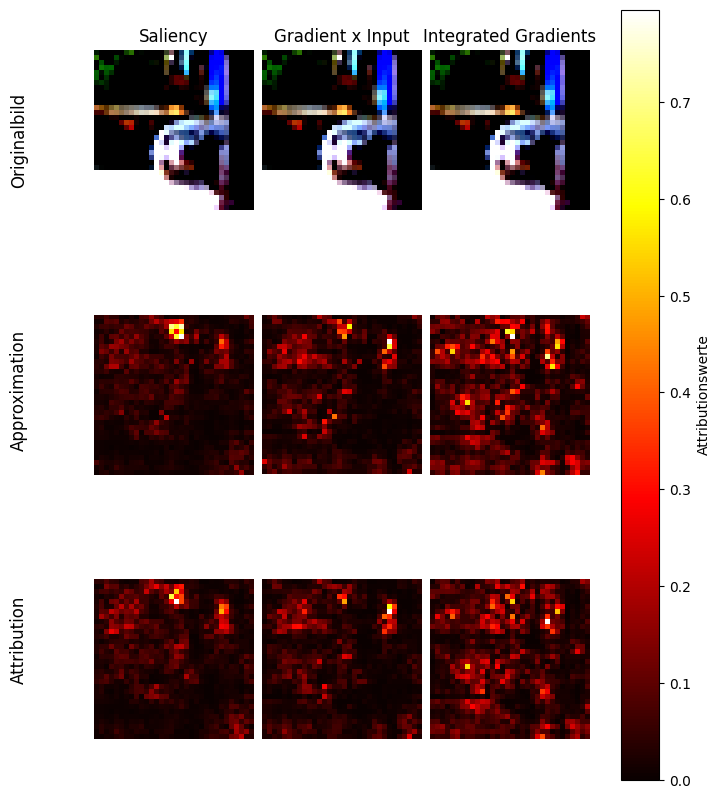

In [6]:

model = model_CNN
aa = ApproxAttribution(model)
sal = Saliency(model)
IxG = InputXGradient(model)
ig = IntegratedGradients(model)

idx = np.random.randint(0, len(dataset) - 1)

plt.style.use('default')

fig, axes = plt.subplots(3, 3, figsize=(8,10))
fig.set_facecolor('white')

axes[0, 0].set_title('Saliency')
axes[0, 1].set_title('Gradient x Input')
axes[0, 2].set_title('Integrated Gradients')

fig.text(0.02, 0.75, 'Originalbild', rotation=90, verticalalignment='center',fontsize=12)
fig.text(0.02, 0.5, 'Approximation', rotation=90, verticalalignment='center',fontsize=12)
fig.text(0.02, 0.25, 'Attribution', rotation=90, verticalalignment='center',fontsize=12)

cnt = 0
for i in range(3):
    img, label = dataset[idx]
    #print(img.shape)
    #print(torch.is_tensor(img))

    if i == 0:
        attribution_map = aa.grad_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = sal.attribute(img.unsqueeze(0).float().to(device), target=label)
    elif i == 1:
        attribution_map = aa.grad_x_i_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = IxG.attribute(img.unsqueeze(0).float().to(device), target=label)
    elif i == 2:
        attribution_map = aa.int_grad_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = ig.attribute(img.unsqueeze(0).float().to(device), target=label,baselines=torch.zeros_like(img.unsqueeze(0), dtype=torch.float).to(device)) #.detach().cpu().numpy()

    print(attribution_map.shape)
    attribution_map = attribution_map.detach().cpu().numpy()
    attribution_map_real = attribution_map_real.squeeze().detach().cpu().numpy()

    attr_vis = np.abs(attribution_map).max(axis=0)
    attr_real_vis = np.abs(attribution_map_real).max(axis=0)
    print(attr_real_vis.shape)
    image_np = to_numpy_image(img)

    im = axes[0,i].imshow(image_np)
    axes[0,i].axis('off')

    im1 = axes[1,i].imshow(attr_vis, cmap='hot')
    axes[1,i].axis('off')

    im2 = axes[2,i].imshow(attr_real_vis, cmap='hot')
    axes[2,i].axis('off')

    cnt = cnt + 1

plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im1, ax=axes.ravel().tolist(), label='Attributionswerte')

plt.savefig("Methoden_Visualisiert.png", bbox_inches='tight')
plt.show()



In [7]:
high = 1.0
mediumhigh = 0.5
medium = 0.01
low = 1e-4

def gen_data(h=high,method="Sal",filename="daten_sal.npz",size=10,baseline='Zero',model=model_CNN):
    aa = ApproxAttribution(model)
    sal = Saliency(model)
    IxG = InputXGradient(model)
    ig = IntegratedGradients(model)

    attr = []
    approx = []
    idx =[]
    for i in range(size):
        idx.append(np.random.randint(0, len(dataset) - 1))
    cnt = 0
    for i in idx:
        cnt = cnt + 1
        img, label = dataset[i]
        if method == "Sal":
            approx.append(aa.grad_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            attr.append(sal.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())
        if method == "GxI":
            approx.append(aa.grad_x_i_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            attr.append(IxG.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())
        if method == "Int":
            approx.append(aa.int_grad_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            attr.append(ig.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())

    attr_flat = [np.array(r).flatten() for r in attr]
    approx_flat = [np.array(a).flatten() for a in approx]


    attr_flat = np.array(attr_flat)
    approx_flat = np.array(approx_flat)
    np.savez(filename, arr1=attr_flat,arr2=approx_flat)

gen_data(h=low,method="Sal",filename="CNN_Sal_10_h=1e-4.npz",size=10,model=model_CNN)

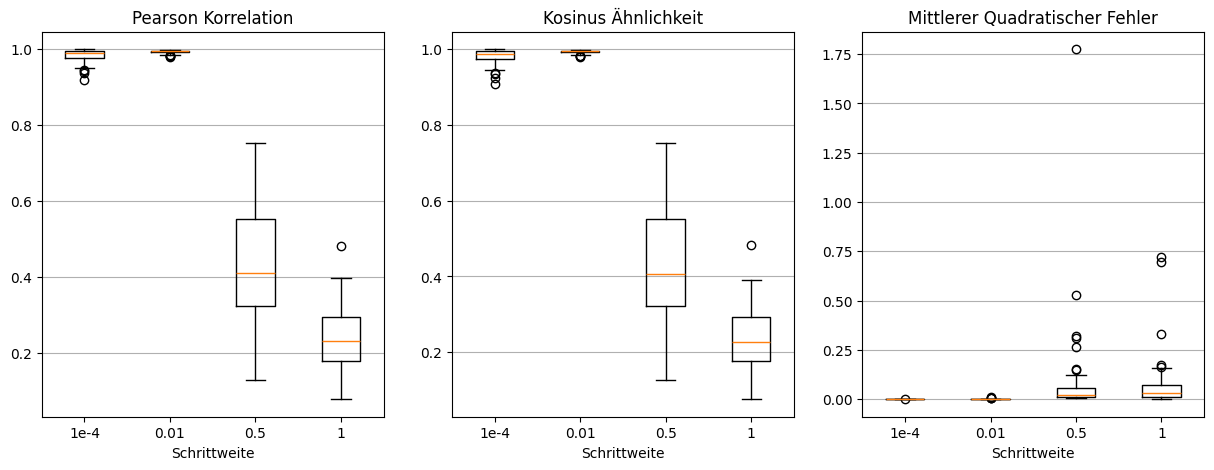

In [14]:
data_low = np.load("Approximated_Data/ResNet50_GxI_50_low.npz")
data_medium = np.load("Approximated_Data/ResNet50_GxI_50_medium.npz")
data_medium_high = np.load("Approximated_Data/ResNet50_GxI_50_mediumhigh.npz")
data_high = np.load("Approximated_Data/ResNet50_GxI_50_high.npz")

real_low = data_low["arr1"]
approx_low = data_low["arr2"]

real_medium = data_medium["arr1"]
approx_medium = data_medium["arr2"]

real_medium_high = data_medium_high["arr1"]
approx_medium_high = data_medium_high["arr2"]

real_high = data_high["arr1"]
approx_high = data_high["arr2"]


# Listen, um Ergebnisse zu speichern
pearson_list_low = []
mse_list_low = []
cosine_list_low = []

pearson_list_medium = []
mse_list_medium = []
cosine_list_medium = []

pearson_list_medium_high = []
mse_list_medium_high = []
cosine_list_medium_high = []

pearson_list_high = []
mse_list_high = []
cosine_list_high = []

for i in range(real_low.shape[0]):
    rl = real_low[i]
    al = approx_low[i]

    rm = real_medium[i]
    am = approx_medium[i]

    rmh = real_medium_high[i]
    amh = approx_medium_high[i]

    rh = real_high[i]
    ah = approx_high[i]

    # Pearson-Korrelation
    pearson = np.corrcoef(rl, al)[0, 1]
    pearson_list_low.append(pearson)

    pearson = np.corrcoef(rm, am)[0, 1]
    pearson_list_medium.append(pearson)

    pearson = np.corrcoef(rmh, amh)[0, 1]
    pearson_list_medium_high.append(pearson)

    pearson = np.corrcoef(rh, ah)[0, 1]
    pearson_list_high.append(pearson)


    # MSE
    mse = mean_squared_error(rl, al)
    mse_list_low.append(mse)

    mse = mean_squared_error(rm, am)
    mse_list_medium.append(mse)

    mse = mean_squared_error(rmh, amh)
    mse_list_medium_high.append(mse)

    mse = mean_squared_error(rh, ah)
    mse_list_high.append(mse)


    # Cosine Similarity
    cos = cosine_similarity(rl.reshape(1, -1), al.reshape(1, -1))[0, 0]
    cosine_list_low.append(cos)

    cos = cosine_similarity(rm.reshape(1, -1), am.reshape(1, -1))[0, 0]
    cosine_list_medium.append(cos)

    cos = cosine_similarity(rmh.reshape(1, -1), amh.reshape(1, -1))[0, 0]
    cosine_list_medium_high.append(cos)

    cos = cosine_similarity(rh.reshape(1, -1), ah.reshape(1, -1))[0, 0]
    cosine_list_high.append(cos)


fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Pearson
axs[0].boxplot([pearson_list_low,pearson_list_medium,pearson_list_medium_high,pearson_list_high])
axs[0].set_title('Pearson Korrelation')

axs[0].yaxis.grid(True)
axs[0].set_xticks([y + 1 for y in range(4)],
                labels=['1e-4', '0.01', '0.5', '1'])
axs[0].set_xlabel('Schrittweite')



# Cosine
axs[1].boxplot([cosine_list_low,cosine_list_medium,cosine_list_medium_high,cosine_list_high])
axs[1].set_title('Kosinus Ähnlichkeit')

axs[1].yaxis.grid(True)
axs[1].set_xticks([y + 1 for y in range(4)],
                labels=['1e-4', '0.01', '0.5', '1'])
axs[1].set_xlabel('Schrittweite')



# MSE
axs[2].boxplot([mse_list_low,mse_list_medium,mse_list_medium_high,mse_list_high])
axs[2].set_title('Mittlerer Quadratischer Fehler')

axs[2].yaxis.grid(True)
axs[2].set_xticks([y + 1 for y in range(4)],
                labels=['1e-4', '0.01', '0.5', '1'])
axs[2].set_xlabel('Schrittweite')



plt.savefig("Boxplot_Int_RestNet50.png", bbox_inches='tight')
plt.show()

In [9]:
data_low = np.load("Approximated_Data/CNN_Int_20_low.npz")
data_medium = np.load("Approximated_Data/ResNet18_Int_20_low.npz")
data_high = np.load("Approximated_Data/ResNet50_Int_20_low.npz")

realCNN = data_low["arr1"]

realResNet18 = data_medium["arr1"]

realResNet50 = data_high["arr1"]


print("CNN min:",np.min(realCNN))
print("CNN max:",np.max(realCNN))

print("ResNet18 min:",np.min(realResNet18))
print("ResNet18 max:",np.max(realResNet18))

print("ResNet50 min:",np.min(realResNet50))
print("ResNet50 max:",np.max(realResNet50))

CNN min: -3.960871
CNN max: 4.084076
ResNet18 min: -0.83515334
ResNet18 max: 0.82022727
ResNet50 min: -9.192508
ResNet50 max: 9.545301
